In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt
import pickle as pkl

# Create Data

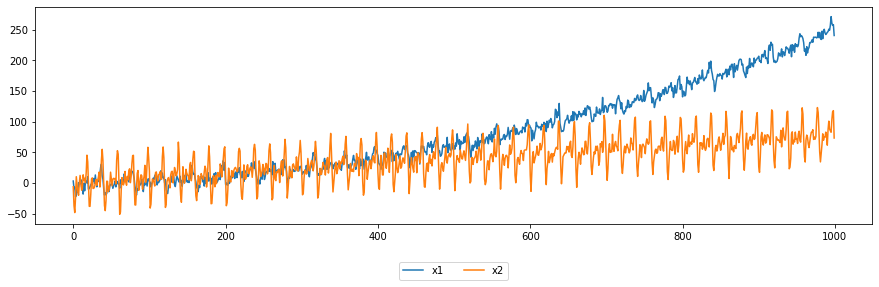

In [2]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([5*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [3]:
print('correlation between x1 and x2: {}'.format(spearmanr(x1, x2)))

correlation between x1 and x2: SpearmanrResult(correlation=0.7678834318834319, pvalue=3.0436345197508617e-195)


# Prepare Data

### Add Index

In [4]:
x_index = np.array(range(len(t)))

### Split

In [5]:
train_ratio = 0.8
train_len = int(train_ratio*x_index.shape[0])
print(train_len)

800


### Detrend

In [6]:
# assume we already know the order of trend
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.33429717e-04  1.17690851e-02 -1.55583408e+00]
[ 0.08070647 -0.80538326]


In [7]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

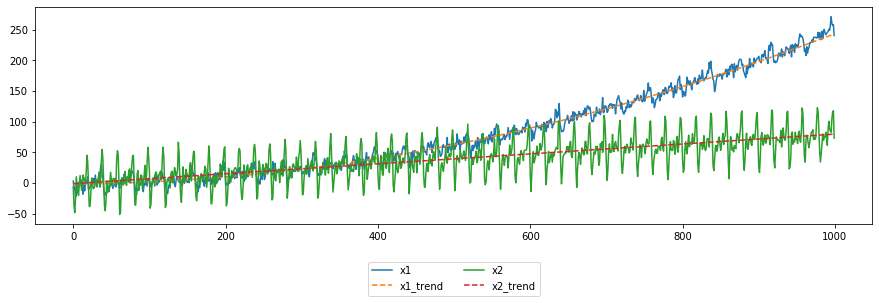

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')

plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

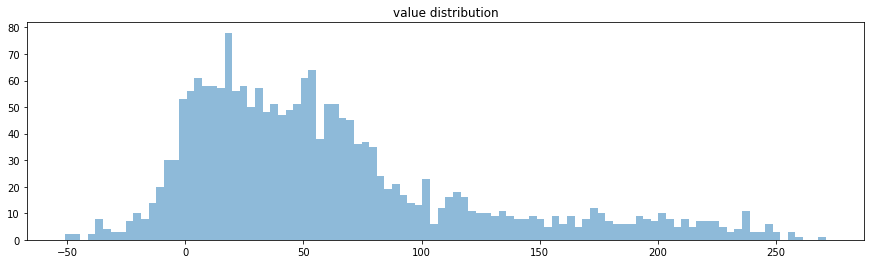

In [9]:
plt.figure(figsize=(15, 4))
plt.hist(np.column_stack([x1, x2]).flatten(), bins=100, alpha=0.5)
plt.title('value distribution')
plt.show()

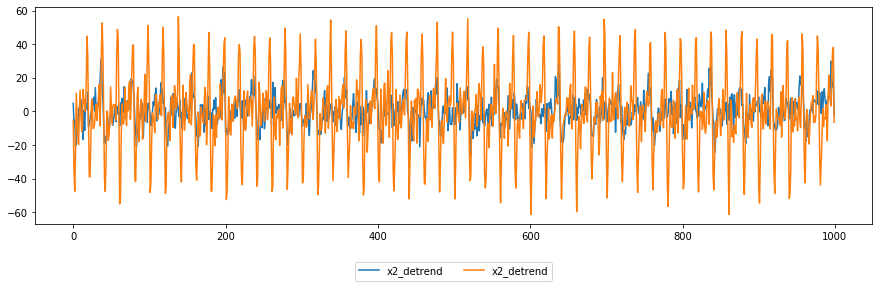

In [10]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Combine

In [11]:
# x_lbl columns: ===================
# columns1: detrended x1, 
# columns2: detrended x2, 
# columns3: index
# columns4: 1 for train set, 0 for test set

x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  4.80766721  -5.29684234   0.           1.        ]
 [ -7.40390531 -36.22167582   1.           1.        ]
 [ -5.25926457 -47.51993105   2.           1.        ]
 ...
 [ 14.62743529  36.54239349 997.           0.        ]
 [ 15.32335942  38.14646739 998.           0.        ]
 [ -2.79157328  -6.48987812 999.           0.        ]]


### Normalize

In [12]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[31.768519764419295, 56.35190753184294, 1, 1]


In [13]:
# x_lbl columns: ===================
# columns1: normalized detrended x1, 
# columns2: normalized detrended x2, 
# columns3: index
# columns4: 1 for train set, 0 for test set

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[ 1.51334316e-01 -9.39957948e-02  0.00000000e+00  1.00000000e+00]
 [-2.33057925e-01 -6.42776392e-01  1.00000000e+00  1.00000000e+00]
 [-1.65549563e-01 -8.43271029e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 4.60438050e-01  6.48467729e-01  9.97000000e+02  0.00000000e+00]
 [ 4.82344142e-01  6.76933028e-01  9.98000000e+02  0.00000000e+00]
 [-8.78723121e-02 -1.15166964e-01  9.99000000e+02  0.00000000e+00]]


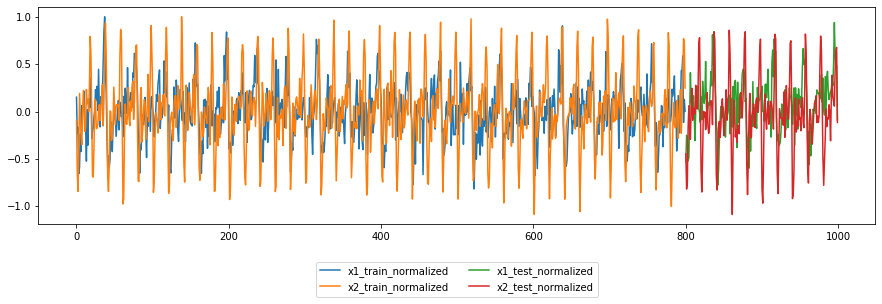

In [14]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Truncate

In [15]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
    

In [16]:
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [17]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]

X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]

print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


In [18]:
pkl.dump({'X_input_train': X_input_train, 
          'X_output_train': X_output_train, 
          'X_input_test': X_input_test, 
          'X_output_test': X_output_test, 
          'x1_trend_param': x1_trend_param,
          'x2_trend_param': x2_trend_param, 
          'x_train_max': x_train_max
         }, open('data.pkl', 'wb'))